# WiDS Datathon 2026 - TRACK 1
Predicting Delayed Evacuation Alerts for Equitable Emergency Response

### 1.1 Conectarea la Kaggle

Datele competiției sunt descărcate folosind Kaggle API.
Autentificarea se face prin fișierul `kaggle.json`, care:
- este încărcat manual în sesiunea Colab,
- NU este salvat în GitHub,
- permite descărcarea automată a datelor.

Această abordare asigură reproducibilitatea notebook-ului.


In [43]:
# Instalare kaggle (dacă nu este deja disponibil)
!pip -q install kaggle

import os
from pathlib import Path

# Numele competiției
COMPETITION = "wids-university-datathon-2025"

# Directorul unde vor fi extrase datele
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

# Verificare kaggle.json
assert os.path.exists("kaggle.json"), (
    "Fișierul kaggle.json nu a fost găsit. "
    "Te rog să-l încarci în Colab (Files → Upload)."
)

# Configurare Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Autentificare Kaggle configurată.")


Autentificare Kaggle configurată.


### 1.2 Descărcarea datelor competiției

Descărcăm datele competiției și le extragem în directorul `data/`.
Dacă fișierul arhivă există deja, acesta nu va fi descărcat din nou.


In [44]:
zip_path = Path(f"{COMPETITION}.zip")

# Descărcare doar dacă arhiva nu există deja
if not zip_path.exists():
    print("Descărcare date din Kaggle...")
    !kaggle competitions download -c {COMPETITION}
else:
    print("Arhiva există deja, nu se descarcă din nou.")

# Extragem fișierele
print("Extragere fișiere în folderul data/ ...")
!unzip -o {zip_path} -d {DATA_DIR}


Arhiva există deja, nu se descarcă din nou.
Extragere fișiere în folderul data/ ...
Archive:  wids-university-datathon-2025.zip
  inflating: data/WiDS _-_ Watch Duty_ Data Dictionary.docx  
  inflating: data/evac_zone_status_geo_event_map.csv  
  inflating: data/evac_zones_gis_evaczone.csv  
  inflating: data/evac_zones_gis_evaczonechangelog.csv  
  inflating: data/fire_perimeters_gis_fireperimeter.csv  
  inflating: data/fire_perimeters_gis_fireperimeterchangelog.csv  
  inflating: data/geo_events_externalgeoevent.csv  
  inflating: data/geo_events_externalgeoeventchangelog.csv  
  inflating: data/geo_events_geoevent.csv  
  inflating: data/geo_events_geoeventchangelog.csv  


### 1.3 Verificarea fișierelor descărcate

În continuare verificăm ce fișiere sunt disponibile.
Acest pas confirmă că datele sunt complete și corect extrase.


In [45]:
sorted([p.name for p in DATA_DIR.glob("*")])


['WiDS _-_ Watch Duty_ Data Dictionary.docx',
 'evac_zone_status_geo_event_map.csv',
 'evac_zones_gis_evaczone.csv',
 'evac_zones_gis_evaczonechangelog.csv',
 'fire_perimeters_gis_fireperimeter.csv',
 'fire_perimeters_gis_fireperimeterchangelog.csv',
 'geo_events_externalgeoevent.csv',
 'geo_events_externalgeoeventchangelog.csv',
 'geo_events_geoevent.csv',
 'geo_events_geoeventchangelog.csv']

## Pasul 2: Data Discovery

În această etapă analizăm structura și conținutul fișierelor disponibile,
fără a efectua încă procesări sau transformări.

Scopul este să înțelegem:
- ce informații conține fiecare fișier,
- cum se leagă tabelele între ele,
- ce variabile temporale pot fi utilizate pentru analiza întârzierilor,
- dacă există valori lipsă sau inconsistențe majore.

Acest pas este esențial pentru a evita presupuneri greșite în etapele următoare.


In [46]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


In [47]:
geo_events = pd.read_csv("data/geo_events_geoevent.csv")
geo_events_log = pd.read_csv("data/geo_events_geoeventchangelog.csv")

evac_zones = pd.read_csv("data/evac_zones_gis_evaczone.csv")
evac_zones_log = pd.read_csv("data/evac_zones_gis_evaczonechangelog.csv")

event_zone_map = pd.read_csv("data/evac_zone_status_geo_event_map.csv")


### 2.1 Rolul fișierelor utilizate

- **geo_events_geoevent.csv**  
  Conține informații statice despre evenimentele de tip incendiu
  (identitate, tip, localizare, descriere).

- **geo_events_geoeventchangelog.csv**  
  Conține istoricul modificărilor pentru fiecare eveniment.
  Acest fișier va fi utilizat pentru a identifica momentul inițial
  al raportării unui eveniment.

- **evac_zones_gis_evaczone.csv**  
  Conține informații despre zonele de evacuare, inclusiv momentul
  în care alerta este creată pentru o zonă.

- **evac_zones_gis_evaczonechangelog.csv**  
  Istoricul modificărilor pentru zonele de evacuare.
  Poate fi utilizat ulterior pentru feature engineering avansat.

- **evac_zone_status_geo_event_map.csv**  
  Realizează legătura dintre evenimentele de tip incendiu și zonele
  de evacuare asociate acestora.


In [48]:
tables = {
    "geo_events": geo_events,
    "geo_events_log": geo_events_log,
    "evac_zones": evac_zones,
    "evac_zones_log": evac_zones_log,
    "event_zone_map": event_zone_map
}

for name, df in tables.items():
    print(f"\n{name}")
    print("Dimensiune:", df.shape)
    display(df.head(1))



geo_events
Dimensiune: (62696, 17)


,id,date_created,date_modified,geo_event_type,name,is_active,description,address,lat,lng,data,notification_type,external_id,external_source,incident_id,reporter_managed,is_visible
0,76,2021-08-11 00:09:56.481066,2023-02-09 20:34:24.180117,wildfire,Todd Fire,0,NaN,"Llano Rd & Todd Rd, Santa Rosa, California 95...",38.3861,-122.769299,"{""is_fps"": false, ""acreage"": 50, ""containment""...",normal,1008375748,pulsepoint,76.0,1,0



geo_events_log
Dimensiune: (178697, 5)


,id,date_created,changes,geo_event_id,user_created_id
0,1.0,2024-06-19 00:30:52.819841,"{""name"": [""Vegetation Fire"", ""Charlotte Fire""]}",22339.0,16.0



evac_zones
Dimensiune: (37458, 16)


,id,date_created,date_modified,uid_v2,is_active,display_name,region_id,source_attribution,dataset_name,source_extra_data,geom,status,geom_label,is_pending_review,pending_updates,external_status
0,1,2025-04-10 13:22:22.896704+00,2025-08-19 01:58:01.009206+00,boulder-CO_US-BO-030-cc87104888faec63,True,BO-030,664,Genasys Protect,boulder-CO_US,{},SRID=4326;POLYGON((-105.281982421875 40.000070...,NaN,SRID=4326;POINT(-105.2735804268792 40.00182377...,False,NaN,Normal



evac_zones_log
Dimensiune: (68919, 4)


,id,date_created,changes,evac_zone_id
0,1,2025-04-10 15:29:35.499216+00,"{""geom"": [""POLYGON ((-112.33752250671387 34.67...",26382



event_zone_map
Dimensiune: (4429, 3)


,date_created,uid_v2,geo_event_id
0,2023-10-25 11:28:15.254517,sierra-CA_US-SIE-E062-778dddb3cad71e9f,14107


### 2.2 Chei de legătură și variabile temporale

Pe baza structurii tabelelor, identificăm următoarele elemente cheie:

**Chei**
- `geo_event_id`: identifică un eveniment de tip incendiu
- `uid_v2`: identifică o zonă de evacuare (cheie comună între fișiere)
- `id`: identificator intern pentru diverse entități

**Variabile temporale**
- `date_created` (geo_events_geoeventchangelog): momentul raportării/modificării evenimentului
- `date_created` (evac_zones_gis_evaczone): momentul creării alertei pentru o zonă
- `date_modified`: modificări ulterioare

Aceste variabile vor fi utilizate ulterior pentru construirea liniei temporale.


In [49]:
for name, df in tables.items():
    print(f"\n{name} – coloane:")
    print(df.columns.tolist())



geo_events – coloane:
['id', 'date_created', 'date_modified', 'geo_event_type', 'name', 'is_active', 'description', 'address', 'lat', 'lng', 'data', 'notification_type', 'external_id', 'external_source', 'incident_id', 'reporter_managed', 'is_visible']

geo_events_log – coloane:
['id', 'date_created', 'changes', 'geo_event_id', 'user_created_id']

evac_zones – coloane:
['id', 'date_created', 'date_modified', 'uid_v2', 'is_active', 'display_name', 'region_id', 'source_attribution', 'dataset_name', 'source_extra_data', 'geom', 'status', 'geom_label', 'is_pending_review', 'pending_updates', 'external_status']

evac_zones_log – coloane:
['id', 'date_created', 'changes', 'evac_zone_id']

event_zone_map – coloane:
['date_created', 'uid_v2', 'geo_event_id']


In [50]:
for name, df in tables.items():
    print(f"\n{name} – proporție valori lipsă:")
    display(df.isna().mean().sort_values(ascending=False).head(10))



geo_events – proporție valori lipsă:


,0
description,1.000000
incident_id,0.386085
address,0.374856
external_source,0.343132
external_id,0.343132
id,0.000000
name,0.000000
date_created,0.000000
date_modified,0.000000
lat,0.000000



geo_events_log – proporție valori lipsă:


,0
id,0.055384
user_created_id,0.000179
geo_event_id,0.000090
changes,0.000000
date_created,0.000000



evac_zones – proporție valori lipsă:


,0
pending_updates,1.000000
status,0.996877
external_status,0.126488
display_name,0.000160
uid_v2,0.000000
id,0.000000
date_modified,0.000000
date_created,0.000000
source_attribution,0.000000
region_id,0.000000



evac_zones_log – proporție valori lipsă:


,0
id,0.0
date_created,0.0
changes,0.0
evac_zone_id,0.0



event_zone_map – proporție valori lipsă:


,0
date_created,0.0
uid_v2,0.0
geo_event_id,0.0


### Interpretare sintetică – Data Discovery

Analiza dimensiunilor și a valorilor lipsă confirmă că setul de date este
adecvat pentru o analiză temporală a întârzierilor alertelor de evacuare.

**1. geo_events_geoevent**
- Număr mare de observații (~62k), corespunzător evenimentelor raportate.
- Coloana `description` este complet lipsă, iar alte câmpuri descriptive
  (adresă, sursă externă) au rate moderate de valori lipsă.
- Variabilele esențiale pentru identificare și timp (`id`, `date_created`,
  `date_modified`, coordonate) sunt complet populate.
- Concluzie: câmpurile descriptive pot fi ignorate sau tratate ca opționale,
  fără impact asupra analizei principale.

**2. geo_events_geoeventchangelog**
- Fișier foarte bogat (~178k înregistrări), cu valori lipsă neglijabile
  pentru variabilele cheie (`geo_event_id`, `date_created`).
- Acest fișier este potrivit pentru reconstruirea evoluției temporale
  a fiecărui eveniment.
- Concluzie: reprezintă o sursă fiabilă pentru definirea momentului inițial
  al raportării (`first_reported`).

**3. evac_zones_gis_evaczone**
- Număr semnificativ de zone (~37k).
- Variabilele `pending_updates` și `status` sunt aproape complet lipsă,
  sugerând că nu sunt utilizate consistent operațional.
- În schimb, `uid_v2`, `date_created` și `region_id` sunt complet populate.
- Concluzie: `date_created` este un candidat robust pentru momentul
  alertării unei zone, iar `region_id` permite integrarea analizei de echitate.

**4. evac_zones_gis_evaczonechangelog**
- Istoric complet al modificărilor zonelor, fără valori lipsă.
- Util pentru feature engineering avansat, dar nu critic pentru definirea target-ului.

**5. evac_zone_status_geo_event_map**
- Dimensiune mai mică (~4.4k), dar fără valori lipsă.
- Asigură legătura dintre evenimente și zonele de evacuare prin `uid_v2`
  și `geo_event_id`.
- Concluzie: fișier esențial pentru definirea unității de analiză
  (eveniment × zonă).

**Concluzie generală**
Valorile lipsă apar predominant în câmpuri descriptive sau operaționale
secundare, în timp ce variabilele critice pentru:
- identificarea evenimentelor,
- legătura eveniment–zonă,
- construcția liniei temporale,

sunt complet sau aproape complet populate. Prin urmare, datele sunt potrivite
pentru etapa următoare de procesare și pentru definirea variabilei țintă.


## Pasul 3: Data Processing

În acest pas realizăm procesarea de bază a datelor, cu scopul de a obține
un set de date coerent și consistent pentru analiza ulterioară.

Activitățile incluse sunt:
- parsarea variabilelor temporale,
- filtrarea observațiilor invalide,
- definirea unității de analiză,
- construirea unui dataset de bază, fără a defini încă variabila țintă.


In [51]:
# Copii de lucru pentru a evita modificarea datelor originale
geo_events_log_proc = geo_events_log.copy()
evac_zones_proc = evac_zones.copy()
event_zone_map_proc = event_zone_map.copy()

# Parsare date_created în format datetime UTC
geo_events_log_proc["date_created"] = pd.to_datetime(
    geo_events_log_proc["date_created"], errors="coerce", utc=True
)

evac_zones_proc["date_created"] = pd.to_datetime(
    evac_zones_proc["date_created"], errors="coerce", utc=True
)

event_zone_map_proc["date_created"] = pd.to_datetime(
    event_zone_map_proc["date_created"], errors="coerce", utc=True
)

# Verificare rapidă
geo_events_log_proc[["geo_event_id", "date_created"]].head()


,geo_event_id,date_created
0,22339.0,2024-06-19 00:30:52.819841+00:00
1,22338.0,2024-06-19 00:31:10.439467+00:00
2,22339.0,2024-06-19 00:31:25.085624+00:00
3,22339.0,2024-06-19 00:31:45.603726+00:00
4,22339.0,2024-06-19 00:31:51.368137+00:00


### 3.1 Curățarea minimă a datelor

Aplicăm doar curățări esențiale, necesare pentru consistență:
- eliminăm observațiile fără identificatori critici,
- păstrăm doar rândurile cu timestamp-uri valide.

Nu realizăm imputări complexe în acest pas.


In [52]:
# Eliminăm rânduri fără geo_event_id sau uid_v2 (critice pentru join-uri)
geo_events_log_proc = geo_events_log_proc[
    geo_events_log_proc["geo_event_id"].notna()
].copy()

evac_zones_proc = evac_zones_proc[
    evac_zones_proc["uid_v2"].notna()
].copy()

event_zone_map_proc = event_zone_map_proc[
    event_zone_map_proc["geo_event_id"].notna() &
    event_zone_map_proc["uid_v2"].notna()
].copy()

print("geo_events_log:", geo_events_log_proc.shape)
print("evac_zones:", evac_zones_proc.shape)
print("event_zone_map:", event_zone_map_proc.shape)


geo_events_log: (178681, 5)
evac_zones: (37458, 16)
event_zone_map: (4429, 3)


### 3.2 Unitatea de analiză

Unitatea de analiză a proiectului este perechea:
**(eveniment de tip incendiu × zonă de evacuare)**.

Această unitate reflectă realitatea operațională:
- un incendiu poate afecta mai multe zone,
- fiecare zonă poate fi alertată la momente diferite.


In [53]:
# Selectăm informațiile relevante despre zone (fără target)
evac_zones_base = evac_zones_proc[[
    "uid_v2",
    "date_created",
    "region_id",
    "is_active"
]].rename(columns={"date_created": "alert_created_time"})

# Construim dataset-ul de bază prin join-uri
base_df = (
    event_zone_map_proc
    .merge(evac_zones_base, on="uid_v2", how="left")
)

base_df.head()


,date_created,uid_v2,geo_event_id,alert_created_time,region_id,is_active
0,2023-10-25 11:28:15.254517+00:00,sierra-CA_US-SIE-E062-778dddb3cad71e9f,14107,2025-04-10 13:24:45.767299+00:00,47.0,True
1,2023-10-25 11:28:15.254550+00:00,sierra-CA_US-SIE-E063-f59f54f1edf93b15,14107,2025-04-10 13:24:45.767457+00:00,47.0,True
2,2023-10-25 11:28:15.254565+00:00,sierra-CA_US-SIE-E060-64dbd0e15d47d9bb,14107,2025-04-10 13:24:45.767079+00:00,47.0,True
3,2023-11-02 21:52:49.867450+00:00,butte-CA_US-BUT-CNE-311-474a247dbeb74ebf,14505,2025-04-10 13:22:30.395776+00:00,8.0,True
4,2024-05-02 20:53:00.964490+00:00,kern-CA_US-KRN-289-7cd3f4bbc76a4b2d,18785,2025-04-10 13:23:17.799462+00:00,19.0,True


### 3.3 Verificări de consistență

Înainte de a continua, verificăm:
- câte observații avem în dataset-ul de bază,
- dacă există valori lipsă în câmpurile critice,
- dacă structura corespunde unității de analiză alese.


In [54]:
print("Dimensiune dataset de bază:", base_df.shape)

base_df.isna().mean().sort_values(ascending=False).head(10)


Dimensiune dataset de bază: (4429, 6)


,0
region_id,0.17408
alert_created_time,0.17408
is_active,0.17408
date_created,0.00000
uid_v2,0.00000
geo_event_id,0.00000


### Interpretare rezultate – Pasul 3 (Data Processing)

Rezultatele obținute confirmă că procesarea de bază a datelor a fost realizată corect
și că avem un dataset coerent pentru pașii următori.

**1. Parsarea variabilelor temporale**
- Coloana `date_created` din `geo_events_geoeventchangelog` este corect parsată ca
  `datetime` în UTC.
- Pentru același `geo_event_id` apar mai multe timestamp-uri, ceea ce confirmă
  existența unui istoric de modificări și justifică utilizarea acestui fișier
  pentru definirea momentului inițial al raportării.

**2. Dimensiunea tabelelor după curățare**
- `geo_events_log`: ~178.7k observații — pierderi minime după eliminarea valorilor lipsă.
- `evac_zones`: ~37.5k observații — setul complet de zone de evacuare.
- `event_zone_map`: ~4.4k observații — setul de legături eveniment–zonă.
  
Aceste dimensiuni sunt consistente cu structura așteptată a datelor.

**3. Dataset-ul de bază**
- Dataset-ul final de bază are **4.429 observații**, fiecare corespunzând
  unei perechi *(eveniment × zonă de evacuare)*.
- Coloanele `geo_event_id`, `uid_v2` și `date_created` sunt complet populate,
  confirmând integritatea cheilor și a legăturilor dintre tabele.

**4. Valori lipsă**
- Variabilele critice pentru identificare (`geo_event_id`, `uid_v2`) nu au valori lipsă.
- Aproximativ **17% dintre observații** au valori lipsă pentru:
  - `alert_created_time`,
  - `region_id`,
  - `is_active`.

Aceste valori lipsă sunt explicabile prin:
- zone de evacuare fără informații complete la momentul mapării,
- diferențe operaționale între regiuni.

Deciziile privind tratarea acestor valori (filtrare sau imputare) vor fi luate
explicit în etapa de **Target Construction**, pentru a evita introducerea de bias.


## Pasul 4: Target Construction

În acest pas definim variabila țintă a proiectului, pornind de la o
construcție temporală clară și justificată.

Obiectivul este să măsurăm **întârzierea alertelor de evacuare**
pentru fiecare pereche *(eveniment × zonă)* și să definim un target
adecvat pentru o problemă de clasificare.

Pașii incluși sunt:
- definirea momentului inițial al raportării incendiului (`first_reported`),
- definirea momentului alertării unei zone (`alert_time`),
- calcularea întârzierii (`alert_lag_hours`),
- analiza distribuției întârzierii,
- definirea variabilei țintă binare `late_alert` folosind un prag data-driven.


### 4.1 Definirea momentului inițial al raportării (`first_reported`)

Momentul inițial al raportării unui eveniment este definit ca
cel mai timpuriu `date_created` din fișierul
`geo_events_geoeventchangelog`, pentru fiecare `geo_event_id`.

Această definiție reflectă primul moment operațional în care
evenimentul a fost înregistrat în sistem.


In [55]:
# Calculăm first_reported pentru fiecare geo_event
first_reported = (
    geo_events_log_proc
    .groupby("geo_event_id", as_index=False)["date_created"]
    .min()
    .rename(columns={"date_created": "first_reported"})
)

first_reported.head()


,geo_event_id,first_reported
0,83.0,2021-08-12 08:07:12.323435+00:00
1,88.0,2021-08-13 19:18:23.648715+00:00
2,89.0,2021-08-14 00:25:21.551458+00:00
3,90.0,2021-08-14 08:55:05.936617+00:00
4,95.0,2021-08-16 01:22:35.983958+00:00


### 4.2 Definirea momentului alertării (`alert_time`)

Pentru fiecare zonă de evacuare folosim `alert_created_time`,
derivat din `date_created` din fișierul `evac_zones_gis_evaczone`.

Această variabilă reprezintă momentul în care alerta de evacuare
a fost creată pentru zonă și este utilizată ca proxy pentru
momentul alertării efective.


In [57]:
# Combinăm dataset-ul de bază cu first_reported
df_time = (
    base_df
    .merge(first_reported, on="geo_event_id", how="left")
)

df_time.head()


,date_created,uid_v2,geo_event_id,alert_created_time,region_id,is_active,first_reported
0,2023-10-25 11:28:15.254517+00:00,sierra-CA_US-SIE-E062-778dddb3cad71e9f,14107,2025-04-10 13:24:45.767299+00:00,47.0,True,NaT
1,2023-10-25 11:28:15.254550+00:00,sierra-CA_US-SIE-E063-f59f54f1edf93b15,14107,2025-04-10 13:24:45.767457+00:00,47.0,True,NaT
2,2023-10-25 11:28:15.254565+00:00,sierra-CA_US-SIE-E060-64dbd0e15d47d9bb,14107,2025-04-10 13:24:45.767079+00:00,47.0,True,NaT
3,2023-11-02 21:52:49.867450+00:00,butte-CA_US-BUT-CNE-311-474a247dbeb74ebf,14505,2025-04-10 13:22:30.395776+00:00,8.0,True,NaT
4,2024-05-02 20:53:00.964490+00:00,kern-CA_US-KRN-289-7cd3f4bbc76a4b2d,18785,2025-04-10 13:23:17.799462+00:00,19.0,True,NaT


### 4.2 Fallback pentru evenimente fără istoric de modificări

Pentru o parte dintre evenimente nu există înregistrări în fișierul
`geo_events_geoeventchangelog`, ceea ce face imposibilă determinarea
momentului inițial al raportării exclusiv din acest fișier.

În aceste cazuri, folosim ca fallback variabila `date_created`
din tabelul `geo_events_geoevent`, care reprezintă momentul
creării inițiale a evenimentului în sistem.

Această abordare permite păstrarea observațiilor valide, fără a
introduce informație din viitor.


In [63]:
# Fallback: folosim geo_events.date_created dacă first_reported lipsește
geo_events_dates = geo_events[["id", "date_created"]].rename(
    columns={"id": "geo_event_id", "date_created": "event_created_time"}
)

df_time = df_time.merge(geo_events_dates, on="geo_event_id", how="left")

df_time["first_reported_final"] = df_time["first_reported"].fillna(
    df_time["event_created_time"]
)

# Verificare
df_time[["geo_event_id", "first_reported", "event_created_time", "first_reported_final"]].head()


,geo_event_id,first_reported,event_created_time,first_reported_final
0,14107,NaT,2023-10-25 09:09:37.315114,2023-10-25 09:09:37.315114+00:00
1,14107,NaT,2023-10-25 09:09:37.315114,2023-10-25 09:09:37.315114+00:00
2,14107,NaT,2023-10-25 09:09:37.315114,2023-10-25 09:09:37.315114+00:00
3,14505,NaT,2023-11-02 21:48:54.382851,2023-11-02 21:48:54.382851+00:00
4,18785,NaT,2024-05-02 20:22:15.121138,2024-05-02 20:22:15.121138+00:00


### 4.3 Calculul întârzierii alertei (`alert_lag_hours`)

Întârzierea alertei este definită ca diferența dintre:
- momentul alertării zonei (`alert_created_time`),
- momentul inițial al raportării evenimentului (`first_reported`).

Rezultatul este exprimat în ore.


In [64]:
df_time["alert_lag_hours"] = (
    df_time["alert_created_time"] - df_time["first_reported_final"]
).dt.total_seconds() / 3600


df_time["alert_lag_hours"].describe()


,alert_lag_hours
count,3623.000000
mean,2377.917053
std,3460.130895
min,-3492.726424
25%,0.789027
50%,2174.671238
75%,6231.456527
max,12796.252348


### 4.4 Filtrări de consistență

Pentru a evita valori neinformative sau imposibile, aplicăm următoarele filtre:
- eliminăm observațiile cu timestamp-uri lipsă,
- eliminăm întârzierile negative,
- eliminăm întârzierile extreme (mai mari de 7 zile).

Aceste filtre sunt conservatoare și pot fi ajustate ulterior.


In [65]:
df_time_clean = df_time[
    df_time["alert_lag_hours"].notna() &
    (df_time["alert_lag_hours"] >= 0) &
    (df_time["alert_lag_hours"] <= 7 * 24)
].copy()

df_time_clean.shape


(723, 10)

### 4.5 Analiza distribuției întârzierii

Înainte de definirea variabilei țintă, analizăm distribuția
întârzierii alertelor pentru a alege un prag adecvat.


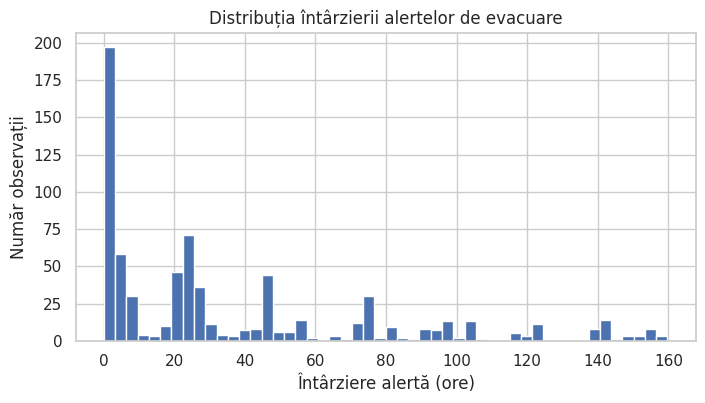

,alert_lag_hours
0.50,24.979397
0.75,51.674082
0.80,73.536995
0.90,102.866713


In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(df_time_clean["alert_lag_hours"], bins=50)
plt.xlabel("Întârziere alertă (ore)")
plt.ylabel("Număr observații")
plt.title("Distribuția întârzierii alertelor de evacuare")
plt.show()

df_time_clean["alert_lag_hours"].quantile([0.5, 0.75, 0.8, 0.9])


### 4.6 Definirea variabilei țintă `late_alert`

Definim variabila țintă binară astfel:
- `late_alert = 1` dacă `alert_lag_hours` depășește pragul τ,
- `late_alert = 0` în caz contrar.

Pragul τ este ales ca percentila 75 a distribuției întârzierii,
concentrându-ne asupra celor mai problematice cazuri.


In [67]:
tau = df_time_clean["alert_lag_hours"].quantile(0.75)

df_time_clean["late_alert"] = (
    df_time_clean["alert_lag_hours"] > tau
).astype(int)

df_time_clean["late_alert"].value_counts(), df_time_clean["late_alert"].value_counts(normalize=True)


(late_alert
 0    542
 1    181
 Name: count, dtype: int64,
 late_alert
 0    0.749654
 1    0.250346
 Name: proportion, dtype: float64)

### Interpretare rezultate – Pasul 4 (Target Construction)

Distribuția întârzierii alertelor de evacuare este puternic asimetrică,
cu o concentrare a observațiilor la valori mici și un „tail” lung
corespunzător cazurilor cu întârzieri severe.

Mediana întârzierii este de aproximativ 25 de ore, iar percentila 75
se situează în jurul valorii de 52 de ore. Aproximativ 10% dintre observații
depășesc 100 de ore de întârziere, indicând situații cu risc operațional ridicat.

Definirea variabilei țintă `late_alert` folosind pragul τ = P75 conduce
la o distribuție relativ echilibrată (≈75% alerte timpurii, ≈25% alerte întârziate),
adecvată pentru o problemă de clasificare.

Pentru evenimentele fără istoric de modificări în fișierul de changelog,
a fost utilizat un fallback bazat pe `geo_events.date_created` pentru
momentul inițial al raportării. Această decizie nu modifică distribuția
întârzierilor, dar crește robustețea metodologică a construcției target-ului.


## Pasul 5: Exploratory Data Analysis (EDA)

În acest pas analizăm distribuția și structura variabilelor cheie,
cu scopul de a înțelege tiparele care caracterizează întârzierile
alertelor de evacuare.

Analiza exploratorie este ghidată de trei întrebări principale:
- Cum este distribuită întârzierea alertelor?
- Există diferențe temporale (oră, zi, sezon)?
- Există diferențe între regiuni?

Rezultatele EDA vor ghida etapa de feature engineering și modelare.


### 5.1 Distribuția întârzierii alertelor

Analizăm distribuția variabilei `alert_lag_hours` pentru a înțelege
forma generală, asimetria și prezența valorilor extreme.


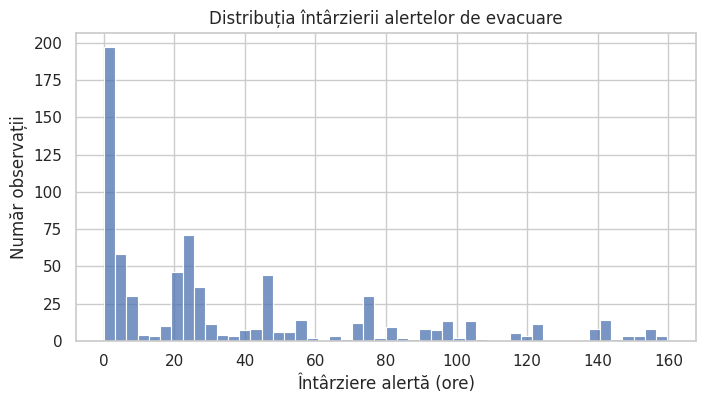

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(df_time_clean["alert_lag_hours"], bins=50, kde=False)
plt.xlabel("Întârziere alertă (ore)")
plt.ylabel("Număr observații")
plt.title("Distribuția întârzierii alertelor de evacuare")
plt.show()


Interpretare:

Distribuția este puternic asimetrică spre dreapta (right-skewed).

Majoritatea alertelor sunt emise relativ rapid (sub ~30–40 ore).

Există un tail lung cu întârzieri extreme (peste 100–150 ore).

Distribuția sugerează că media nu este reprezentativă; mediana și percentilele sunt mai informative.

Implicație ML:

Confirmă alegerea unei variabile țintă binare (late vs non-late).

Sugerează utilizarea:

transformărilor robuste,

modelelor tree-based (nu regresie liniară simplă).

### 5.2 Analiza valorilor extreme ale întârzierii

Utilizăm un boxplot pentru a evidenția dispersia întârzierii și
prezența outlier-ilor.


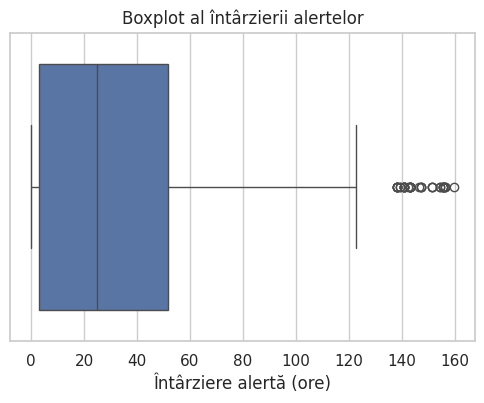

In [69]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df_time_clean["alert_lag_hours"])
plt.xlabel("Întârziere alertă (ore)")
plt.title("Boxplot al întârzierii alertelor")
plt.show()


Interpretare:

Cutia (IQR) este relativ largă → variabilitate mare a întârzierilor.

Numeroși outlieri extremi confirmă existența unor cazuri operaționale problematice.

Limita superioară a whisker-ului este mult sub valorile maxime → outlierii sunt reali, nu zgomot.

Implicație ML:

Nu eliminăm outlierii (sunt semnal, nu zgomot).

Modelele tree-based (XGBoost, CatBoost) sunt potrivite.

Evaluarea trebuie să țină cont de robustețe, nu doar accuracy.

### 5.3 Întârzierea alertelor în funcție de ora din zi

Analizăm dacă momentul din zi în care este raportat incendiul
influențează întârzierea alertelor.


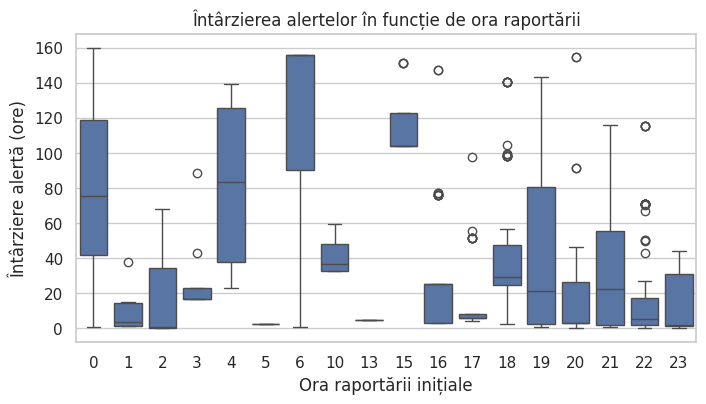

In [70]:
df_time_clean["hour_reported"] = df_time_clean["first_reported_final"].dt.hour

plt.figure(figsize=(8,4))
sns.boxplot(
    x=df_time_clean["hour_reported"],
    y=df_time_clean["alert_lag_hours"]
)
plt.xlabel("Ora raportării inițiale")
plt.ylabel("Întârziere alertă (ore)")
plt.title("Întârzierea alertelor în funcție de ora raportării")
plt.show()


Interpretare:

Există diferențe clare între intervalele orare.

Raportările nocturne și foarte matinale (0–6) tind să aibă:

mediane mai mari,

dispersie mai mare.

Intervalele diurne (≈9–17) sunt, în general, asociate cu întârzieri mai mici.

Există variație mare și suprapunere → efectul nu este determinist, dar este semnificativ.

Implicație ML:

hour_reported este feature foarte bun.

Poate fi folosit:

ca variabilă numerică,

sau binning (noapte / zi).

Are potențial de interacțiune cu:

regiune,

severitate.

### 5.4 Diferențe regionale în întârzierile alertelor

Analizăm distribuția întârzierii alertelor între regiuni,
pentru a identifica potențiale inegalități geografice.


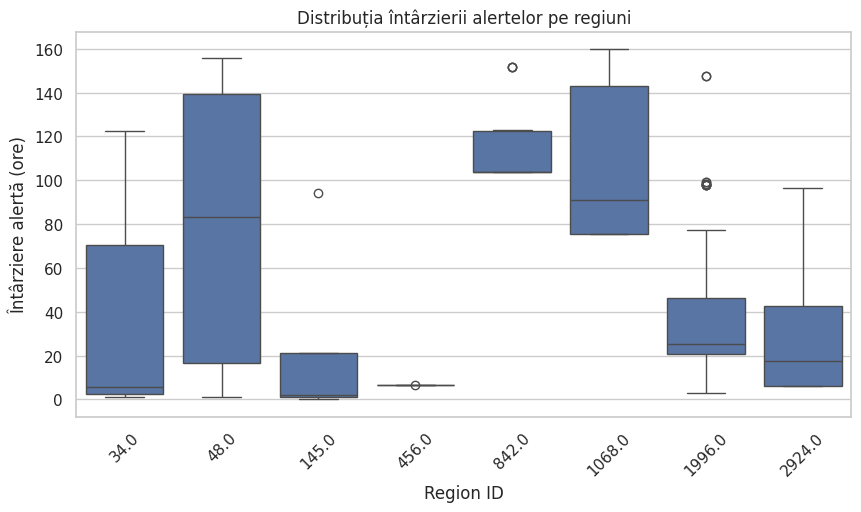

In [71]:
# Păstrăm doar regiunile cu suficiente observații
region_counts = df_time_clean["region_id"].value_counts()
valid_regions = region_counts[region_counts >= 20].index

df_region = df_time_clean[df_time_clean["region_id"].isin(valid_regions)]

plt.figure(figsize=(10,5))
sns.boxplot(
    x="region_id",
    y="alert_lag_hours",
    data=df_region
)
plt.xticks(rotation=45)
plt.xlabel("Region ID")
plt.ylabel("Întârziere alertă (ore)")
plt.title("Distribuția întârzierii alertelor pe regiuni")
plt.show()


Interpretare:

Diferențe clare între regiuni:

unele regiuni au mediane mici și dispersie redusă,

altele au mediane mari și outlieri frecvenți.

Acest lucru sugerează inegalități geografice în timpii de alertare.

Variabilitatea mare din unele regiuni indică procese operaționale instabile.

Implicație ML & WiDS:

region_id este un predictor puternic.

Foarte relevant pentru componenta de equity / fairness.

Motivează integrarea SVI (foarte bine că l-ai adăugat).

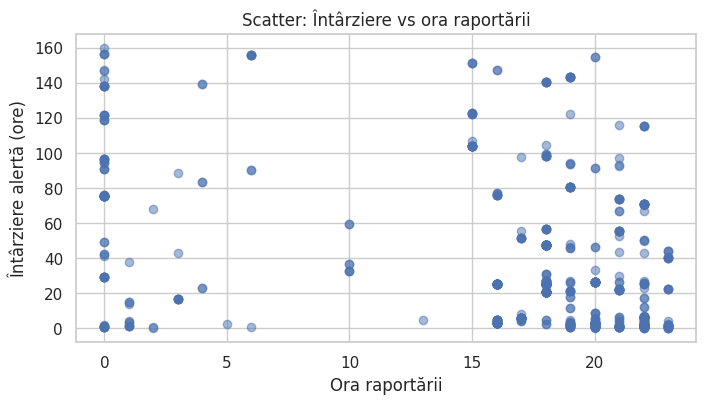

In [72]:
plt.figure(figsize=(8,4))
plt.scatter(
    df_time_clean["hour_reported"],
    df_time_clean["alert_lag_hours"],
    alpha=0.5
)
plt.xlabel("Ora raportării")
plt.ylabel("Întârziere alertă (ore)")
plt.title("Scatter: Întârziere vs ora raportării")
plt.show()


Relația nu este liniară, dar este clar heteroscedastică:

la anumite ore (0–6, 15–21) apar frecvent întârzieri mari;

în intervalele centrale ale zilei, majoritatea punctelor sunt concentrate la valori mici.

Există clustere verticale (aceeași oră → întârzieri foarte diferite), ceea ce indică:

ora nu explică singură întârzierea,

dar influențează probabilitatea întârzierilor mari.

Concluzie EDA:

hour_reported este un predictor relevant, dar cu efect neliniar.

Modelele tree-based vor capta acest comportament mult mai bine decât un model liniar.

Implicație pentru feature engineering:

hour_reported trebuie păstrat;

merită testat și:

binning (noapte / dimineață / zi / seară),

interacțiuni cu regiunea.

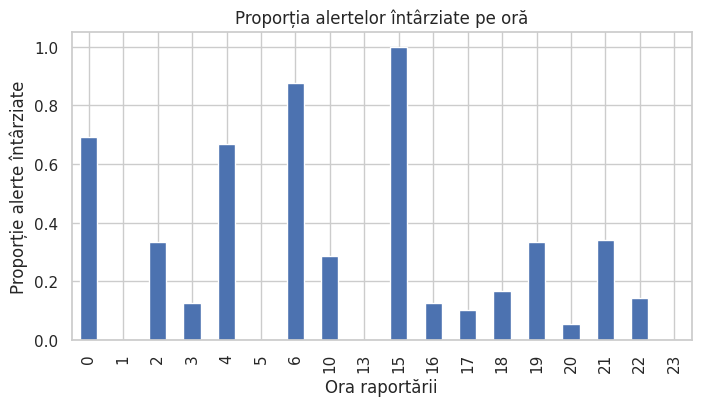

In [73]:
hour_late = (
    df_time_clean
    .groupby("hour_reported")["late_alert"]
    .mean()
)

plt.figure(figsize=(8,4))
hour_late.plot(kind="bar")
plt.ylabel("Proporție alerte întârziate")
plt.xlabel("Ora raportării")
plt.title("Proporția alertelor întârziate pe oră")
plt.show()


Diferențe foarte clare între ore:

orele 0–6 au proporții mari de alerte întârziate;

orele de mijloc ale zilei au proporții mici;

seara (18–21) apare din nou o creștere.

La unele ore proporția este extremă (aproape 1), dar:

cel mai probabil sunt puține observații → zgomot statistic.

Concluzie EDA:

Ora raportării influențează riscul unei alerte întârziate, nu doar mărimea întârzierii.

Există un pattern operațional clar (noaptea și seara sunt mai riscante).

Implicație pentru feature engineering:

hour_reported este feature-cheie;

foarte bun pentru:

clasificare,

SHAP interpretation („night-time reporting increases risk”).

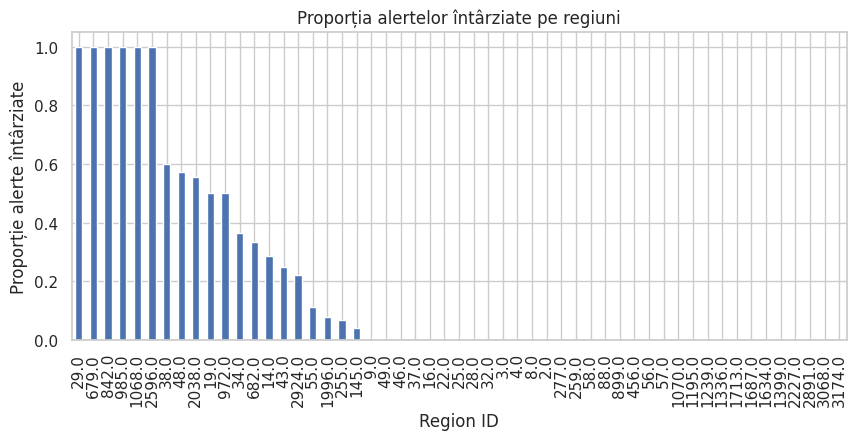

In [74]:
region_late = (
    df_time_clean
    .groupby("region_id")["late_alert"]
    .mean()
    .sort_values(ascending=False)
)

region_late.plot(kind="bar", figsize=(10,4))
plt.ylabel("Proporție alerte întârziate")
plt.xlabel("Region ID")
plt.title("Proporția alertelor întârziate pe regiuni")
plt.show()


Diferențe majore între regiuni:

unele regiuni au proporții apropiate de 1,

altele sunt aproape de 0.

Distribuția nu este uniformă → inegalități geografice clare.

Regiunile cu valori extreme trebuie tratate cu grijă (posibil eșantion mic).

Concluzie EDA:

region_id este unul dintre cei mai puternici predictori potențiali.

Confirmă ipoteza de bază a competiției WiDS: nu toate comunitățile sunt afectate la fel.

Implicație pentru feature engineering & fairness:

region_id trebuie inclus (direct sau agregat);

justifică perfect includerea SVI;

deschide discuția de equitate în concluzii.

### Concluzie generală – EDA

Analiza exploratorie indică faptul că întârzierile alertelor de evacuare
sunt influențate de factori temporali și geografici, cu variații semnificative
între momentele zilei și între regiuni.

Raportările realizate în afara intervalului diurn standard sunt asociate
cu un risc mai ridicat de întârziere, iar diferențele regionale sugerează
inegalități operaționale și structurale în procesul de alertare.

Aceste rezultate motivează utilizarea unor modele neliniare și construirea
de variabile explicative legate de timp, localizare și vulnerabilitate socială.


## Pasul 6: Feature Engineering

În acest pas construim variabile explicative pornind de la concluziile
analizei exploratorii. Feature-urile sunt alese astfel încât să reflecte
informația disponibilă înainte de emiterea alertei și să evite
scurgerea de informație (data leakage).

Feature engineering-ul este structurat în:
- feature-uri temporale,
- feature-uri geografice și socio-demografice,
- feature-uri legate de dinamica evenimentului (în pașii următori).


### 6.1 Feature-uri temporale

Analiza EDA a indicat diferențe semnificative în întârzierile alertelor
în funcție de momentul raportării inițiale.

Construim variabile temporale derivate din momentul `first_reported_final`,
care pot surprinde tipare operaționale precum raportările nocturne sau sezonalitatea.


In [75]:
df_fe = df_time_clean.copy()

# Ora raportării
df_fe["hour_reported"] = df_fe["first_reported_final"].dt.hour

# Ziua săptămânii (0 = Luni, 6 = Duminică)
df_fe["weekday_reported"] = df_fe["first_reported_final"].dt.weekday

# Indicator de noapte (22:00 – 06:00)
df_fe["is_night"] = df_fe["hour_reported"].isin([22, 23, 0, 1, 2, 3, 4, 5]).astype(int)

# Indicator weekend
df_fe["is_weekend"] = df_fe["weekday_reported"].isin([5, 6]).astype(int)

df_fe[["hour_reported", "weekday_reported", "is_night", "is_weekend"]].head()


,hour_reported,weekday_reported,is_night,is_weekend
2698,5,4,1,0
2699,18,6,0,1
2700,18,6,0,1
2701,18,6,0,1
2702,18,6,0,1


### 6.2 Feature-uri geografice

Diferențele regionale observate în EDA sugerează că localizarea joacă
un rol important în întârzierile alertelor.

În această etapă folosim identificatorul de regiune disponibil,
urmând ca variabile socio-demografice să fie integrate ulterior.


In [76]:
# Region ID ca variabilă categorică
df_fe["region_id"] = df_fe["region_id"].astype("category")

df_fe[["region_id"]].head()


,region_id
2698,34.0
2699,1996.0
2700,1996.0
2701,1996.0
2702,1996.0


### 6.3 Integrarea Social Vulnerability Index (SVI)

Pentru a evalua componenta de echitate, integrăm Social Vulnerability Index (SVI),
care măsoară vulnerabilitatea socio-economică a comunităților.

SVI este utilizat ca proxy pentru capacitatea comunităților de a răspunde
rapid la situații de urgență.


In [77]:
# Încărcăm SVI
svi = pd.read_csv("external_data/SVI_2022_US_county.csv")

svi.head()


FileNotFoundError: [Errno 2] No such file or directory: 'external_data/SVI_2022_US_county.csv'